# FDMS - TME4 - BAGGING ET BOOSTING
Borchani Slim / Ghiles Reguig
## Travail demandé: 
* Implémentation du Bagging
    - Tester le modèle sur des arbres de décisions
    - Evaluer l'erreur en géneralisation par rapport à un arbre unique

* Implémentation Boosting
    - Applications sur des stumps
    - Erreur d'apprentissage et en test en fonction du nombre de classifieur
    - Analyse des points associés aux poids les plus élevés
    - Géneralisation en fonction de la profondeur des arbres

## Import :

In [1]:
%matplotlib inline

import numpy as np
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
import matplotlib.pyplot as plt

## Algorithme du Bagging

L'algorithme du Bagging consiste à prédire sur un jeu de donnée à l'aide de plusieurs classifieurs, et de récuperer pour chaque prédiction, la prédiction qui a le plus d'occurences.
Ainsi cet algorithme permet d'améliorer la stabilitée de certaines procédure en réduisant la variance et en évitant le sur-apprentissage.

## Code Bagging: 

In [2]:
class Bagging(object) :
    
    def __init__(self, base_clf=tree.DecisionTreeClassifier(), nbClf=10, percTrain=0.66):
        self.base_clf = base_clf
        self.nbClf = nbClf
        self.bag = [clone(self.base_clf) for _ in range(nbClf)]
        self.percTrain = percTrain
        
    def fit(self, x, y):
        index = range(len(x))
        nbTrain = int(self.percTrain*len(x))
        
        #On train le modèle
        for clf in self.bag:
            np.random.shuffle(index)
            i = index[:nbTrain]
            clf.fit(x[i], y[i])
            
    def predict(self, x):
        #On récupère le argmax qui possède le plus d'occurence 
        self.preds = np.array([clf.predict(x) for clf in self.bag]).T
        return np.array([np.argmax(np.bincount(pred)) for pred in self.preds])
        
    def score(self, x, y):
        pred = self.predict(x)
        return (y.reshape(pred.shape) == pred).mean()

## DataSet :

In [3]:
dataset = load_iris()
x = dataset['data']
y = dataset['target']

## Performances du Bagging en fonction du nombre de classifieur et son erreur en géneralisation par rapport à un arbre unique

In [4]:
#Test sur plusieurs valeur de nbClf
nbClf = [1,2,5,10,20,50,100,200,500,750,1000]

predBag = []
predArbre = []
varBag = []
varArbre = []

for i in nbClf:
    predBagmoy = []
    predArbremoy = []
  
    #On fait une moyenne pour arrondir les courbes
    for j in range(0,5):
        #Initialisation
        b = Bagging(nbClf = i)
        xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3)
        
        #On entraine le modèle puis on prédit
        b.fit(xTrain, yTrain)
        Pred = b.predict(xTest)
        
        #On récupère le score pour bagging
        score = b.score(xTest,yTest)
        predBagmoy.append(score)
        
        #On récupere score pour arbre
        t = tree.DecisionTreeClassifier()
        t.fit(xTrain, yTrain)
        predArbremoy.append(t.score(xTest, yTest))
    
    #Erreur = 1 - Score 
    varBag.append(np.std(predBagmoy))
    varArbre.append(np.std(predArbremoy))
    predBag.append(1 - np.mean(predBagmoy))
    predArbre.append(1 - np.mean(predArbremoy))
    
    
plt.figure()
plt.errorbar(nbClf, predBag, yerr=varBag)
plt.errorbar(nbClf, predArbre, yerr=varArbre)
#plt.plot(nbClf,predBag)
#plt.plot(nbClf,predArbre)
plt.legend(["predBag", "predArbre"])
plt.title("Erreur du bagging en fonction du nombre de classifieur")

TypeError: 'range' object does not support item assignment

Quel que soit la valeur du nombre de classsifieur à utiliser pour prédire les données en test, l'erreur est autour des 0,04, notre modèle ne sur-apprend pas.
Son erreur en géneralisation est assez identique à l'arbre unique d'sklearn. 

## Algorithme du Boosting :

L'algorithme du Boosting consiste à faire une sélection itérative de classifieur faible  en fonction d'une distribution des exemples d'apprentissage. Chaque exemple est pondéré en fonction de sa difficulté avec le classifieur courant.

## Code Boosting :

In [5]:
class Boosting(object):
    
    def __init__(self,classifier = DecisionTreeClassifier(max_depth = 1),maxClassifiers = 100,seuil=0.001):
        self.classifier = classifier
        self.maxClassifiers = maxClassifiers
        self.seuil = seuil
    
    def fit(self,datax,datay):
        
        #Poids associes a chaque exemple
        self.weights = np.array([1.0/datax.shape[0]]*datax.shape[0])
        self.w_histo = []
        self.w_histo.append(self.weights)
        
        nbClassif = 0
        erreur = self.seuil + 1
        
        self.alphas = []
        self.classifs = []
        normZ = datax.shape[0]
        
        while(nbClassif <= self.maxClassifiers and erreur > self.seuil):
            
            #fit du classifieur
            self.classifier = clone(self.classifier)
            c = self.classifier
            c.fit(datax,datay,sample_weight = self.weights)
            predictions = c.predict(datax)

            #Calcul de l'erreur
            erreur = predictions != datay
            erreur = np.sum(self.weights * erreur)

            #Calcul de la valeur alpha
            if (erreur != 0):
                alpha = 0.5 * np.log((1-erreur)/erreur)
            else : 
                alpha = 1.0

            #Ajout de la valeur alpha a la liste des valeurs alpha
            self.alphas.append(alpha)
            
            #Ajout du classifieur a la liste des classifieurs
            self.classifs.append(c)
            
            #Calcul du coefficient de normalisation
            expErreurAlpha = np.exp(-1.0*alpha*datay*predictions)

            #Mise a jour des poids
            self.weights = self.weights * expErreurAlpha
            normZ = np.sum(self.weights)
            self.weights=self.weights / normZ
            self.w_histo.append(self.weights)
            #Creation d'un nouveau classifieur
            nbClassif += 1
            
    def predict(self,datax):
        prediction = np.sum([self.alphas[i] * self.classifs[i].predict(datax) for i in range(len(self.classifs))],axis=0)
        return np.sign(prediction)
    
    def score(self, x, y):
        pred = self.predict(x)
        return (y.reshape(pred.shape) == pred).mean()

Si un classifieur ne gère pas naturellement les pondérations il suffit de lui donner la valeur n fois, avec n correspondant au poids associé à la valeur. Par exemple avec X de poids 1, Y de poids 2 et Z de poids 3, il suffit de lui 1 X, 2 Y, et 3 Z.

## Dataset :

In [6]:
dataset = datasets.load_breast_cancer()
x = dataset['data']
y = dataset['target']
y[y==0]=-1

## Courbes d'erreur en Test et en Train en fonction du nombre de classifieurs.

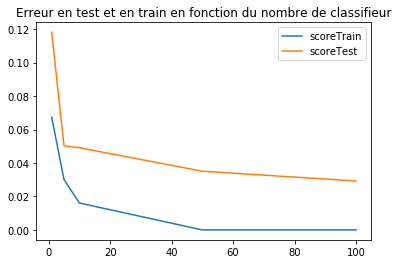

In [8]:
scoreTrain = []
scoreTest =[]

val = [1, 5, 10, 50, 100]#, 200, 500, 1000,2000,5000]

for i in val:
    scorusTest = []
    scorusTrain = []
    for j in range(0,5):
        xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3) 
        boosting = Boosting(maxClassifiers = i)
        boosting.fit(xTrain, yTrain)
        scorusTrain.append(boosting.score(xTrain,yTrain))
        scorusTest.append(boosting.score(xTest,yTest))
    
    scoreTest.append(1-np.mean(scorusTest))
    scoreTrain.append(1-np.mean(scorusTrain))
    
plt.figure()
plt.plot(val,scoreTrain)
plt.plot(val,scoreTest)
plt.legend(["scoreTrain", "scoreTest"])
plt.title("Erreur en test et en train en fonction du nombre de classifieur")


L'erreur en test et en apprentissage est faible et constante, de l'ordre de 0,04.

## Affichage des points associés aux poids les plus élevés,  et leur évolutions en fonction du  nombre de classifieur.

In [ ]:
val = [1, 5, 10, 50, 100, 200, 500, 1000,2000,5000]

boosting = Boosting(maxClassifiers = 1)
boosting.fit(xTrain, yTrain)
index = np.argsort(boosting.weights)[-10:]
classifs = []
for i in val:
    
    b = Boosting(maxClassifiers = i)
    b.fit(xTrain, yTrain)
    classifs.append(b.predict(xTrain[index]) == yTrain[index])
    
colors = [['b' if j== True else 'r' for j in i ] for i in classifs]
plt.figure()
for i in range(len(val)):
    #print([val[i]]*len(index))
    plt.scatter(index,[val[i]] * len(index),c=colors[i])
plt.title("Prediction des points ayant les poids les plus lourd en fonction du nombre de classifieurs")

Les points ayant les poids les plus lours sont souvent bien prédis pour tout nombre de classifieur, mais il arrive que pour un nombre de classifieur de 1 , il se trompe. Il faudrait des données beaucoup plus complexes pour analyser celà en détails.

## Géneralisation en fonction de la profondeur des arbres

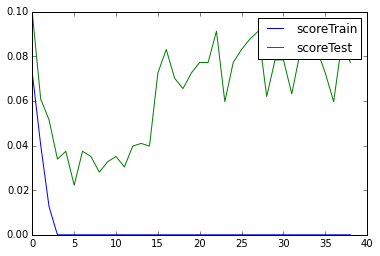

In [56]:
for i in range(1,30):
    scorusTest = []
    scorusTrain = []
    for j in range(0,5):
        xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3) 
        boosting = Boosting(DecisionTreeClassifier(max_depth = i))
        boosting.fit(xTrain, yTrain)
        scorusTrain.append(boosting.score(xTrain,yTrain))
        scorusTest.append(boosting.score(xTest,yTest))
    
    scoreTest.append(1-np.mean(scorusTest))
    scoreTrain.append(1-np.mean(scorusTrain))
    
plt.figure()
plt.plot(scoreTrain)
#plt.title("ScoreTrain")

plt.plot(scoreTest)
plt.legend(["scoreTrain", "scoreTest"])
#plt.title("ScoreTest")

Plus la profondeur des arbres augmente , plus le modèle géneralise et donc l'erreur en test augmente.